# vitalPeriodic

"Periodic" data refers to data which is consistently interfaced from bedside vital signs monitors into eCareManager. Data are generally interfaced as 1 minute averages, and archived into the vitalPeriodic table as 5 minute median values.

The vital signs are **not** validated by care staff, so data quality can vary, but the use of 1 minute averages followed by 5 minute medians before archival removes many spurious readings.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [5]:
from sqlalchemy import create_engine
con= create_engine('postgresql://eicu@localhost:5432/eicu')

## Examine a single patient

In [3]:
patientunitstayid = 145467

In [6]:
query = query_schema + """
select *
from vitalperiodic
where patientunitstayid = {}
order by observationoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.set_index('observationoffset', inplace=True)
df.sort_index(inplace=True)
df.head()

,vitalperiodicid,patientunitstayid,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
observationoffset,,,,,,,,,,,,,,,,,,
8,40613790,145467,NaN,100.0,66.0,9.0,5.0,None,110.0,54.0,71.0,31.0,11.0,18.0,-0.4,0.0,0.2,None
13,40613624,145467,NaN,100.0,65.0,19.0,7.0,None,106.0,53.0,69.0,34.0,17.0,24.0,-0.5,-0.1,0.2,None
18,40613458,145467,NaN,100.0,69.0,32.0,NaN,None,96.0,50.0,65.0,47.0,16.0,23.0,-0.5,-0.1,0.2,None
23,40613292,145467,NaN,100.0,71.0,7.0,NaN,None,111.0,57.0,74.0,36.0,16.0,23.0,-0.4,-0.1,0.1,None
28,40613127,145467,36.8,100.0,72.0,15.0,7.0,None,111.0,59.0,75.0,36.0,18.0,25.0,-0.4,-0.1,0.2,None


In [7]:
df.columns

Index(['vitalperiodicid', 'patientunitstayid', 'temperature', 'sao2',
       'heartrate', 'respiration', 'cvp', 'etco2', 'systemicsystolic',
       'systemicdiastolic', 'systemicmean', 'pasystolic', 'padiastolic',
       'pamean', 'st1', 'st2', 'st3', 'icp'],
      dtype='object')

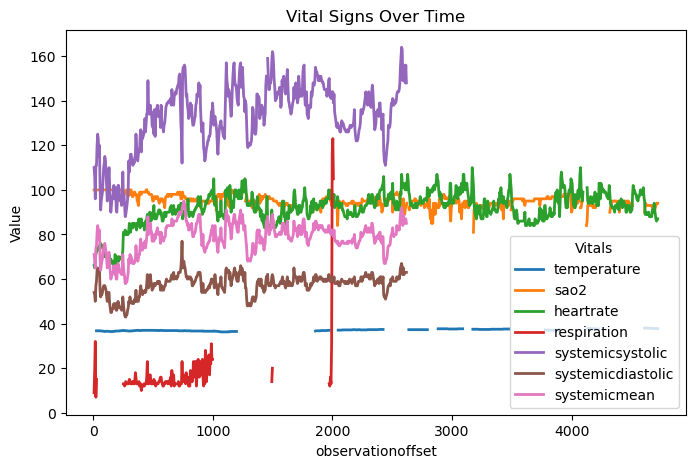

In [10]:
vitals = ['temperature', 'sao2', 'heartrate', 'respiration',
          'systemicsystolic', 'systemicdiastolic', 'systemicmean']

df[vitals].plot(figsize=(8, 5), linewidth=2)

plt.xlabel('observationoffset')  
plt.ylabel('Value')
plt.title('Vital Signs Over Time')

plt.legend(title='Vitals')
plt.show()

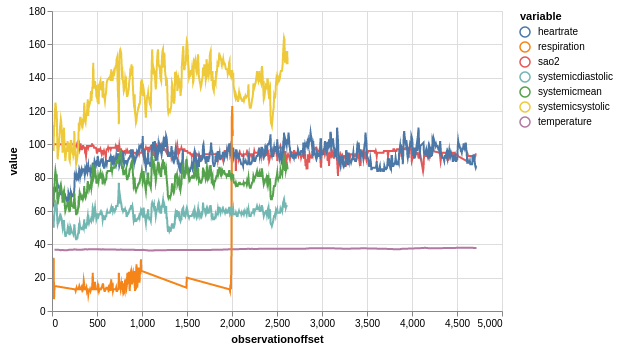

In [7]:
# list of columns to plot
vitals = ['temperature', 'sao2', 'heartrate', 'respiration',
          'systemicsystolic', 'systemicdiastolic', 'systemicmean']
df[vitals].vgplot.line()

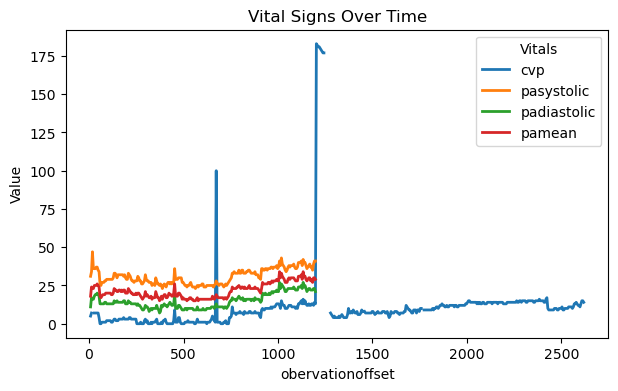

In [12]:
vitals = ['cvp', 'pasystolic', 'padiastolic', 'pamean']

df[vitals].plot(figsize=(7, 4), linewidth=2)

plt.xlabel('obervationoffset')  
plt.ylabel('Value')
plt.title('Vital Signs Over Time')

plt.legend(title='Vitals')
plt.show()

As we can see most data is fairly consistent but there are a few clear outliers for respiration likely due to artifacts around the 2000 minute mark.

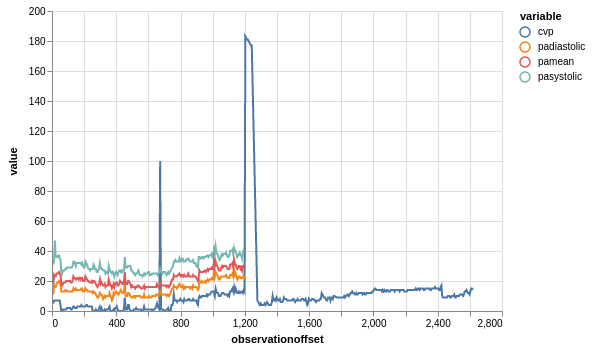

In [10]:
# list of columns to plot
vitals = ['cvp', 'pasystolic', 'padiastolic', 'pamean']
df[vitals].vgplot.line()

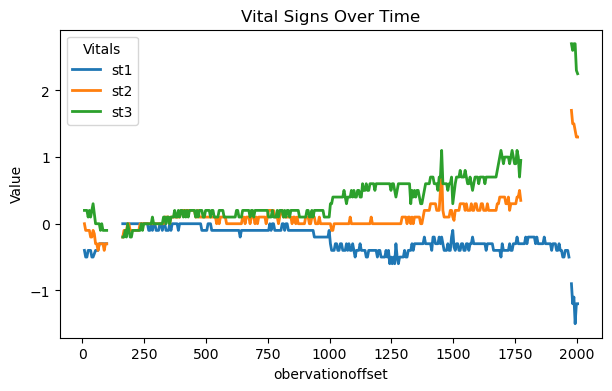

In [13]:
vitals = ['st1', 'st2', 'st3']

df[vitals].plot(figsize=(7, 4), linewidth=2)

plt.xlabel('obervationoffset')  
plt.ylabel('Value')
plt.title('Vital Signs Over Time')

plt.legend(title='Vitals')
plt.show()

Though rare, this patient appears to have pulmonary artery monitoring which ceases at around the 1200 minute mark. This also coincides with a large increase in measured central venous pressure (CVP), which is probably related to the catheter removal.

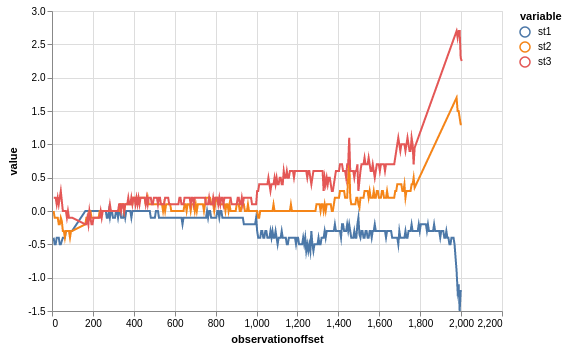

In [12]:
# list of columns to plot
vitals = ['st1', 'st2', 'st3']
# no 'icp' data
df[vitals].vgplot.line()

Machine derived ST segment levels are also available - quantization of the value is done at 0.1 mV and is readily observable.

## Hospitals with data available

In [14]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from vitalperiodic
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6905,97.818388
54,167,6092,5763,94.599475
106,264,5237,5083,97.059385
184,420,4679,4462,95.362257
134,338,4277,4202,98.246434
58,176,4328,4142,95.702403
90,243,4243,4121,97.124676
71,199,4240,3941,92.948113
206,458,3701,3644,98.459876
80,208,3650,3611,98.931507


/var/folders/0y/54ttk0rd3vdgxkwlwgxb5h0m0000gn/T/ipykernel_53053/2582028306.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Data Completion')


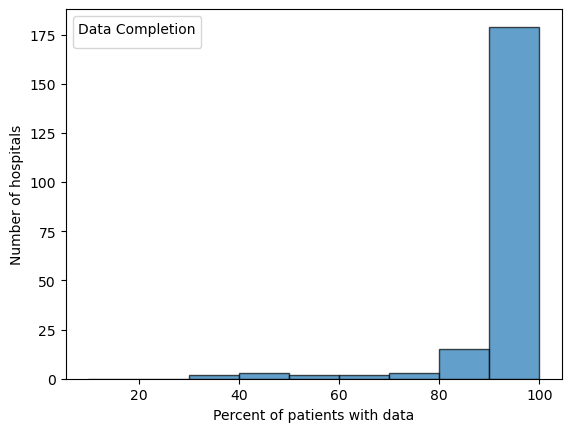

In [15]:
bins=[10,20,30,40,50,60,70,80,90,100]
plt.hist(df['data completion'], bins=bins,  alpha=0.7,edgecolor='black')
plt.xlabel('Percent of patients with data')
plt.ylabel('Number of hospitals')
plt.legend(title='Data Completion')
plt.show()

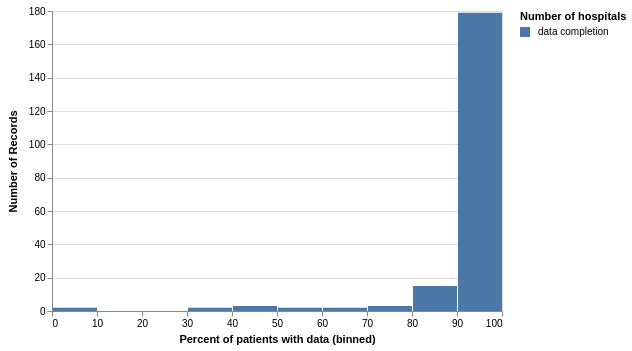

In [14]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

Most hospitals in eICU have good data coverage for the vitalperiodic table.